In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm

delhi_df = pd.read_csv('master_timeseries.csv',parse_dates=[0]).set_index('date')
delhi_monthly_means_df = pd.read_csv('delhi_monthly_means.csv', parse_dates=[0]).set_index('date')

In [12]:
delhi_df.sample(5)

ndti      ndvi  tmmx  Precipitation (mm/day)          aod  \
date                                                                        
2020-10-14       NaN       NaN   NaN                0.000000  2096.670195   
2019-07-31       NaN       NaN   NaN                1.902242          NaN   
2021-11-30       NaN       NaN   NaN                     NaN  1033.433343   
2017-07-26       NaN       NaN   NaN                0.453193          NaN   
2020-02-24 -0.111663  0.315866   NaN                0.000000  1003.494350   

            NO2_column_number_density  avg_rad  \
date                                             
2020-10-14                   0.000257      NaN   
2019-07-31                   0.000110      NaN   
2021-11-30                   0.000143      NaN   
2017-07-26                        NaN      NaN   
2020-02-24                   0.000153      NaN   

            retail_and_recreation_percent_change_from_baseline  
date                                                            
2020-10-14                                              -36.0   
2019-07-31                                                NaN   
2021-11-30                                              -11.0   
2017-07-26                                                NaN   
2020-02-24                                               -1.0

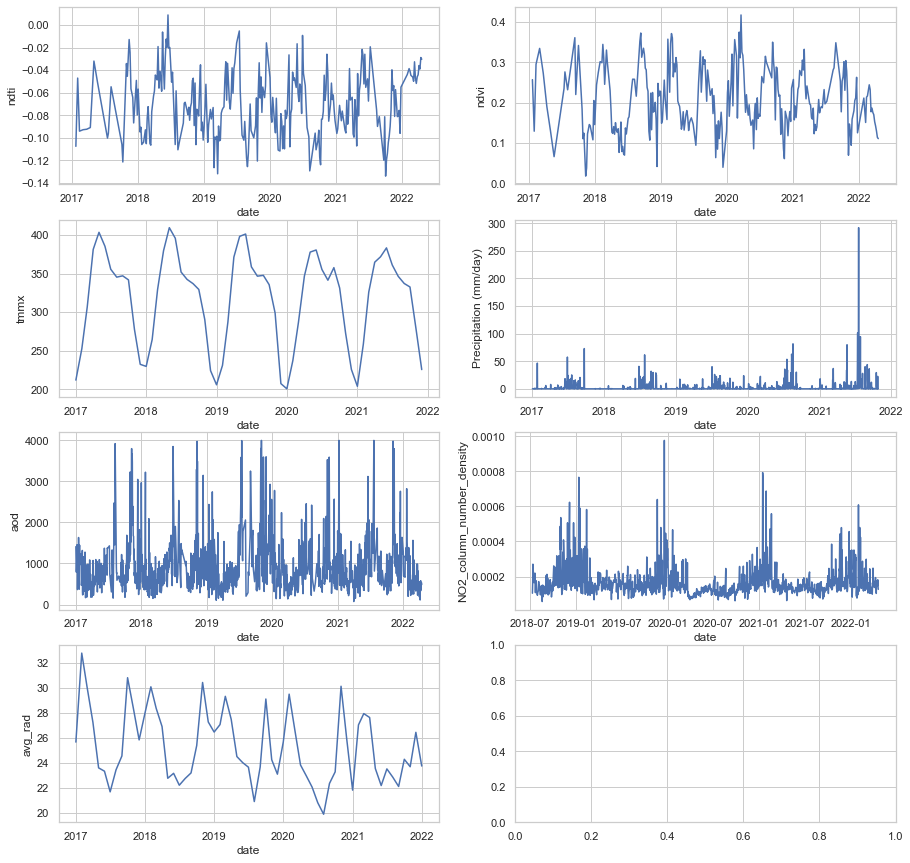

In [10]:
# Time series of all variables being studied
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(nrows=4,ncols=2,figsize=(15,15))
axs = axs.flatten()
for counter, metric in enumerate(delhi_df.columns[:-1]):
    sns.lineplot(x='date', y=metric, data=delhi_df.reset_index(),ax=axs[counter])
plt.show()

In [22]:
from statsmodels.tsa.stattools import adfuller
adfs = []
pvalues=[]
for metric in delhi_df.columns[:-1]:
    X = delhi_df[metric].interpolate(method='linear').dropna()
    result = adfuller(X)
    adfs.append(result[0])
    pvalues.append(result[1])

adf_df = pd.DataFrame([adfs,pvalues],index=['ADF','P-Value'])
adf_df.columns = delhi_df.columns[:-1]
adf_df

ndti      ndvi      tmmx  Precipitation (mm/day)  \
ADF     -5.650442e+00 -5.645620 -5.592937           -8.827375e+00   
P-Value  9.888815e-07  0.000001  0.000001            1.808199e-14   

                  aod  NO2_column_number_density       avg_rad  
ADF     -8.636332e+00                  -3.712873 -6.031114e+00  
P-Value  5.577932e-14                   0.003936  1.417245e-07

From preliminary observation, we can infer that there is seasonality in data. However, environmental variables like Temperature, are cyclo-stationary. Hence, statistical tests like Augmented Dickey-Fuller tests will identify them as stationary. 

We'll first check if the forecasting is good with using the data directly. If it is weak, we will use differencing to remove the seasonality. However, this might come with loss in data.

In [19]:
delhi_df_diff = delhi_df.diff(365)

In [23]:
from statsmodels.tsa.stattools import adfuller
adfs = []
pvalues=[]
for metric in delhi_df_diff.columns[:-1]:
    X = delhi_df_diff[metric].interpolate(method='linear').dropna()
    result = adfuller(X)
    adfs.append(result[0])
    pvalues.append(result[1])

adf_df = pd.DataFrame([adfs,pvalues],index=['ADF','P-Value'])
adf_df.columns = delhi_df_diff.columns[:-1]
adf_df

ndti      ndvi      tmmx  Precipitation (mm/day)           aod  \
ADF     -3.582450 -4.850496 -3.533978           -9.104824e+00 -7.752025e+00   
P-Value  0.006106  0.000043  0.007156            3.525699e-15  9.961563e-12   

         NO2_column_number_density       avg_rad  
ADF                      -5.251123 -6.363073e+00  
P-Value                   0.000007  2.447280e-08

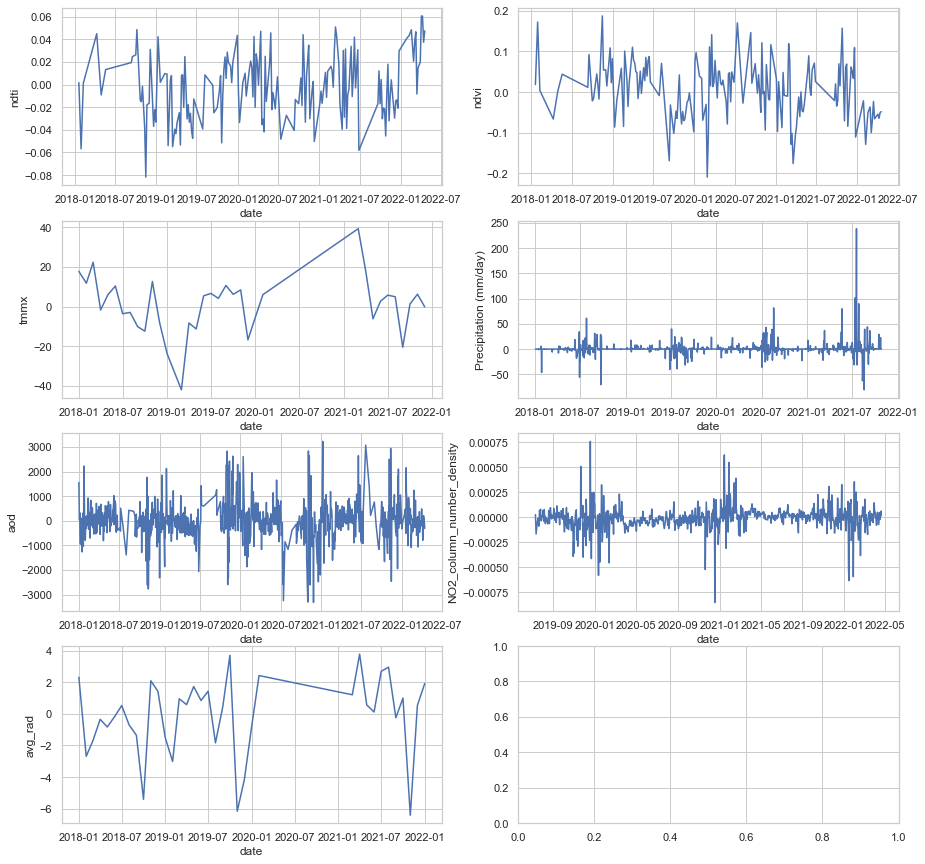

In [24]:
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(nrows=4,ncols=2,figsize=(15,15))
axs = axs.flatten()
for counter, metric in enumerate(delhi_df_diff.columns[:-1]):
    sns.lineplot(x='date', y=metric, data=delhi_df_diff.reset_index(),ax=axs[counter])
plt.show()

We could remove seasonality and trend.

# SARIMAX

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

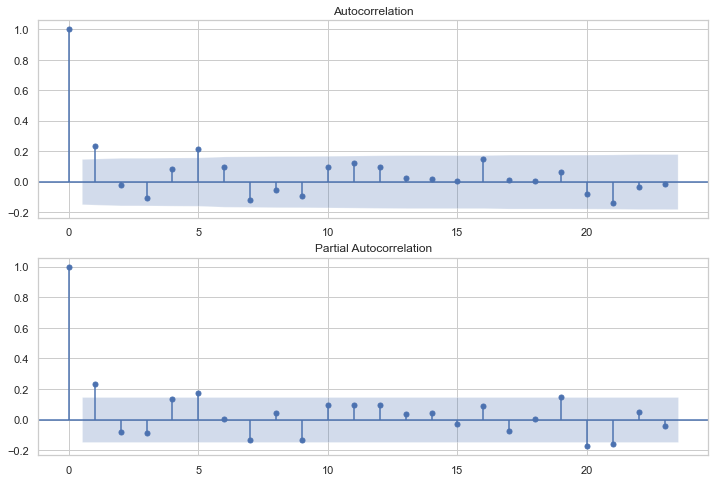

In [53]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,8))
axs = axs.flatten()

fig = plot_acf(delhi_df_diff['NO2_column_number_density'].interpolate().dropna()[:'2019'], ax=axs[0])
fig = plot_pacf(delhi_df_diff['NO2_column_number_density'].interpolate().dropna()[:'2019'], ax=axs[1])

plt.show()

In [113]:
import statsmodels.api as sm
df = delhi_df[['tmmx']].interpolate().dropna()

In [114]:
model = sm.tsa.statespace.SARIMAX(df['tmmx'][:'2019'],
                                     order=(1,1,1),
                                     seasonal_order=(1,1,1,12))
results = model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [115]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARIMA Model Results                                  
=======================================================================================
Dep. Variable:     D.NO2_column_number_density   No. Observations:                  538
Model:                          ARIMA(1, 1, 1)   Log Likelihood                4291.831
Method:                                css-mle   S.D. of innovations              0.000
Date:                         Sat, 30 Apr 2022   AIC                          -8575.663
Time:                                 20:00:17   BIC                          -8558.511
Sample:                             07-12-2018   HQIC                         -8568.954
                                  - 12-31-2019                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                              2.041e-07   5.24e-07      0.389      0.697   -8.23e-07    1.23e-06
ar.L1.D.NO2_column_number_density     0.2545      0.049      5.231      0.000       0.159       0.350
ma.L1.D.NO2_column_number_density    -0.8923      0.040    -22.549      0.000      -0.970      -0.815
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.9298           +0.0000j            3.9298            0.0000
MA.1            1.1206           +0.0000j            1.1206            0.0000
-----------------------------------------------------------------------------
"""

In [116]:
df['forecast'] = model_fit.predict(start='2020-01-01',end='2020-05-31',dynamic=True)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='date'>

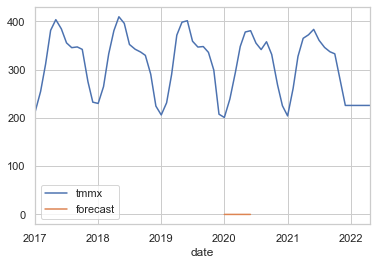

In [117]:
df.plot()

In [109]:
df

tmmx  forecast
date                            
2017-01-01  212.051731       NaN
2017-01-02         NaN       NaN
2017-01-03         NaN       NaN
2017-01-04         NaN       NaN
2017-01-05         NaN       NaN
...                ...       ...
2022-04-18         NaN       NaN
2022-04-19         NaN       NaN
2022-04-20         NaN       NaN
2022-04-21         NaN       NaN
2022-04-22         NaN       NaN

[1938 rows x 2 columns]

In [103]:
control = delhi_df[['tmmx']]['2019'].interpolate(method='linear').reset_index(drop=True)
control.columns=['tmmx_2019']
treatment = delhi_df[['tmmx']]['2020'].interpolate(method='linear').reset_index(drop=True)
treatment.columns=['tmmx_2020']

C:\Users\SAIKRI~1\AppData\Local\Temp/ipykernel_15572/68413760.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  control = delhi_df[['tmmx']]['2019'].interpolate(method='linear').reset_index(drop=True)
C:\Users\SAIKRI~1\AppData\Local\Temp/ipykernel_15572/68413760.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  treatment = delhi_df[['tmmx']]['2020'].interpolate(method='linear').reset_index(drop=True)


<AxesSubplot:>

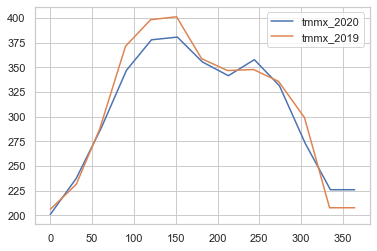

In [104]:
treatment.reset_index().merge(control.reset_index(),on='index').drop('index',axis=1).plot()

In [6]:
!pip install pystan

  ERROR: Command errored out with exit status 1:
   command: 'C:\ProgramData\Anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Sai Krishna\\AppData\\Local\\Temp\\pip-install-pkfbun_v\\pystan_274f5d17c14e45feb58363a697fb89cb\\setup.py'"'"'; __file__='"'"'C:\\Users\\Sai Krishna\\AppData\\Local\\Temp\\pip-install-pkfbun_v\\pystan_274f5d17c14e45feb58363a697fb89cb\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Sai Krishna\AppData\Local\Temp\pip-wheel-jg4dgmt4'
       cwd: C:\Users\Sai Krishna\AppData\Local\Temp\pip-install-pkfbun_v\pystan_274f5d17c14e45feb58363a697fb89cb\
  Complete output (17845 lines):
  Compiling pystan/_api.pyx because it depends on C:\ProgramData\Anaconda3\lib\site-packag


  Using cached pystan-3.4.0-py3-none-any.whl (13 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)
  Using cached pysimdjson-3.2.0-cp39-cp39-win_amd64.whl (157 kB)
  Using cached aiohttp-3.8.1-cp39-cp39-win_amd64.whl (554 kB)
  Using cached pystan-3.3.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.2.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.1.1-py3-none-any.whl (13 kB)
  Using cached pystan-3.1.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.0.2-py3-none-any.whl (13 kB)
  Using cached pystan-3.0.1-py3-none-any.whl (12 kB)
  Using cached pystan-3.0.0-py3-none-any.whl (12 kB)
  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Running setup.py clean for pystan
Failed to build pystan
    Running setup.py install for pystan: started
    Running setup.py install for pystan: finished with status 'error'



  copying pystan\stan\src\stan\io\chained_var_context.hpp -> build\lib.win-amd64-3.9\pystan\stan\src\stan\io
  copying pystan\stan\src\stan\io\cmd_line.hpp -> build\lib.win-amd64-3.9\pystan\stan\src\stan\io
  copying pystan\stan\src\stan\io\dump.hpp -> build\lib.win-amd64-3.9\pystan\stan\src\stan\io
  copying pystan\stan\src\stan\io\empty_var_context.hpp -> build\lib.win-amd64-3.9\pystan\stan\src\stan\io
  copying pystan\stan\src\stan\io\ends_with.hpp -> build\lib.win-amd64-3.9\pystan\stan\src\stan\io
  copying pystan\stan\src\stan\io\is_whitespace.hpp -> build\lib.win-amd64-3.9\pystan\stan\src\stan\io
  copying pystan\stan\src\stan\io\program_reader.hpp -> build\lib.win-amd64-3.9\pystan\stan\src\stan\io
  copying pystan\stan\src\stan\io\random_var_context.hpp -> build\lib.win-amd64-3.9\pystan\stan\src\stan\io
  copying pystan\stan\src\stan\io\reader.hpp -> build\lib.win-amd64-3.9\pystan\stan\src\stan\io
  copying pystan\stan\src\stan\io\read_line.hpp -> build\lib.win-amd64-3.9\pystan

  copying pystan\stan\src\stan\lang\ast\node\break_continue_statement_def.hpp -> build\lib.win-amd64-3.9\pystan\stan\src\stan\lang\ast\node
  copying pystan\stan\src\stan\lang\ast\node\conditional_op.hpp -> build\lib.win-amd64-3.9\pystan\stan\src\stan\lang\ast\node
  copying pystan\stan\src\stan\lang\ast\node\conditional_op_def.hpp -> build\lib.win-amd64-3.9\pystan\stan\src\stan\lang\ast\node
  copying pystan\stan\src\stan\lang\ast\node\conditional_statement.hpp -> build\lib.win-amd64-3.9\pystan\stan\src\stan\lang\ast\node
  copying pystan\stan\src\stan\lang\ast\node\conditional_statement_def.hpp -> build\lib.win-amd64-3.9\pystan\stan\src\stan\lang\ast\node
  copying pystan\stan\src\stan\lang\ast\node\distribution.hpp -> build\lib.win-amd64-3.9\pystan\stan\src\stan\lang\ast\node
  copying pystan\stan\src\stan\lang\ast\node\double_literal.hpp -> build\lib.win-amd64-3.9\pystan\stan\src\stan\lang\ast\node
  copying pystan\stan\src\stan\lang\ast\node\double_literal_def.hpp -> build\lib.win

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\detail\fd_set_adapter.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\detail\fenced_block.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\detail\functional.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\detail\future.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\detail\gcc_arm_fenced_block.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\asio\detail\gcc_hppa_fenced_block.hpp -> build\lib.win-amd6

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\atomic\detail\ops_gcc_arm.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\atomic\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\atomic\detail\ops_gcc_arm_common.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\atomic\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\atomic\detail\ops_gcc_atomic.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\atomic\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\atomic\detail\ops_gcc_ppc.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\atomic\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\atomic\detail\ops_gcc_ppc_common.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\atomic\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\atomic\detail\ops_gcc_sparc.h

  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\interop
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\interop\eigen.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\interop
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\interop\opencv.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\interop
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\interop\opengl.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\interop
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\interop\qt.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\interop
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\interop\vtk.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\compute\interop
  creating build\l

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\container\pmr\monotonic_buffer_resource.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\container\pmr
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\container\pmr\polymorphic_allocator.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\container\pmr
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\container\pmr\pool_options.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\container\pmr
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\container\pmr\resource_adaptor.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\container\pmr
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\container\pmr\set.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\container\pmr
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\container\pmr\slist.hpp 

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include\adapt_assoc_adt_named.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include\adapt_assoc_struct.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include\adapt_assoc_struct_named.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include\adapt_struct.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include\adapt_struct_named.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boos

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include\support.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include\swap.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include\tag_of.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include\tag_of_fwd.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include\transform.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\fusion\include\transformation.hpp -> build\lib.win-amd6

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj\qsc.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj\robin.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj\rouss.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj\rpoly.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geometry\srs\projections\proj\sconics.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\geome

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa\tags.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa\write.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa
  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa\detail\is_allowed.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa\detail\read.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\gil\extension\io\targa\detail\re

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\interprocess\detail\config_begin.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\interprocess\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\interprocess\detail\config_end.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\interprocess\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\interprocess\detail\config_external_begin.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\interprocess\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\interprocess\detail\config_external_end.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\interprocess\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\interprocess\detail\file_locking_helpers.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\interprocess\detail
  copying pystan\s

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\intrusive\detail\config_end.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\intrusive\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\intrusive\detail\default_header_holder.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\intrusive\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\intrusive\detail\ebo_functor_holder.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\intrusive\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\intrusive\detail\empty_node_checker.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\intrusive\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\intrusive\detail\equal_to_value.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\intrusive\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.6

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse\lit.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse\lit_c.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse\look_ahead.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse\middle_of.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse\next_char.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse\next_line.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metap

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse\v1\cpp11\impl\push_back_c.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse\v1\cpp11\impl
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse\v1\cpp11\impl\push_front_c.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse\v1\cpp11\impl
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse\v1\cpp11\impl\remove_trailing_no_chars.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse\v1\cpp11\impl
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse\v1\cpp11\impl\size.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse\v1\cpp11\impl
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse\v1\cpp11\impl\string.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\metaparse\v1\cpp11\impl
  c

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\list\aux_\push_front.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\list\aux_
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\list\aux_\size.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\list\aux_
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\list\aux_\tag.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\list\aux_
  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\list\aux_\preprocessed
  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\list\aux_\preprocessed\plain
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\list\aux_\preprocessed\plain\list10.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\list\aux_\preprocessed\plain
  copying pystan\stan\lib\stan_math\lib

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\vector\aux_\preprocessed\no_ctps\vector50.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\vector\aux_\preprocessed\no_ctps
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\vector\aux_\preprocessed\no_ctps\vector50_c.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\vector\aux_\preprocessed\no_ctps
  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\vector\aux_\preprocessed\plain
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\vector\aux_\preprocessed\plain\vector10.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\vector\aux_\preprocessed\plain
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\vector\aux_\preprocessed\plain\vector10_c.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\mpl\vector\aux_\preprocessed\pla

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\predef\os\irix.h -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\predef\os
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\predef\os\linux.h -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\predef\os
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\predef\os\macos.h -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\predef\os
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\predef\os\os400.h -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\predef\os
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\predef\os\qnxnto.h -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\predef\os
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\predef\os\solaris.h -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\predef\os
  copying pystan\sta

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor\repetition.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor\selection.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor\seq.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor\slot.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor\stringize.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\preprocessor\tuple.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\serialization\traits.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\serialization
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\serialization\type_info_implementation.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\serialization
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\serialization\unique_ptr.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\serialization
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\serialization\unordered_collections_load_imp.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\serialization
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\serialization\unordered_collections_save_imp.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\serialization
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\s

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\data\config.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\data
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\data\dataset.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\data
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\data\for_each_sample.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\data
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\data\index_sequence.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\data
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\data\monomorphic.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\data
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\test\data\size.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\numeric\ublas\matrix_vector.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\numeric\ublas
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\numeric\ublas\operation.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\numeric\ublas
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\numeric\ublas\operations.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\numeric\ublas
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\numeric\ublas\operation_blocked.hpp -> build\lib.win-amd64-3.9\pystan

    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\qvm\vec_mat_operations4.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\qvm
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\qvm\vec_operations.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\qvm
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\qvm\vec_operations2.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\qvm
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\qvm\vec_operations3.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\qvm
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\qvm\vec_operations4.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\qvm
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\qvm\vec_traits.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\qvm
    copying 

    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\include\classic_tree_to_xml.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\include
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\include\classic_typeof.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\include
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\include\classic_utility.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\include
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\include\classic_version.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\include
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\include\classic_while.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\include
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spi

    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_traits\is_detected_exact.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_traits
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_traits\is_empty.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_traits
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_traits\is_enum.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_traits
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_traits\is_final.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_traits
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_traits\is_float.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_traits
    copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\type_traits\is_floating_point.hpp -> build\lib.win-amd64-3.9\

    copying pystan\stan\lib\stan_math\lib\eigen_3.3.3\unsupported\test\cxx11_tensor_complex_cwise_ops_cuda.cu -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\eigen_3.3.3\unsupported\test
    copying pystan\stan\lib\stan_math\lib\eigen_3.3.3\unsupported\test\cxx11_tensor_concatenation.cpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\eigen_3.3.3\unsupported\test
    copying pystan\stan\lib\stan_math\lib\eigen_3.3.3\unsupported\test\cxx11_tensor_const.cpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\eigen_3.3.3\unsupported\test
    copying pystan\stan\lib\stan_math\lib\eigen_3.3.3\unsupported\test\cxx11_tensor_contraction.cpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\eigen_3.3.3\unsupported\test
    copying pystan\stan\lib\stan_math\lib\eigen_3.3.3\unsupported\test\cxx11_tensor_contract_cuda.cu -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\eigen_3.3.3\unsupported\test
    copying pystan\stan\lib\stan_math\lib\eigen_3.3.3\unsupport

    copying pystan\stan\lib\stan_math\stan\math\prim\mat\fun\positive_ordered_constrain.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\stan\math\prim\mat\fun
    copying pystan\stan\lib\stan_math\stan\math\prim\mat\fun\positive_ordered_free.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\stan\math\prim\mat\fun
    copying pystan\stan\lib\stan_math\stan\math\prim\mat\fun\prod.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\stan\math\prim\mat\fun
    copying pystan\stan\lib\stan_math\stan\math\prim\mat\fun\promote_common.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\stan\math\prim\mat\fun
    copying pystan\stan\lib\stan_math\stan\math\prim\mat\fun\promote_elements.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\stan\math\prim\mat\fun
    copying pystan\stan\lib\stan_math\stan\math\prim\mat\fun\promote_scalar.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\stan\math\prim\mat\fun
    copying pystan\stan\lib\stan_math\stan\math\prim\

In [5]:
import pystan

ModuleNotFoundError: No module named 'pystan'